## PDF ANSWERING AI: Preprocess and Fine-tuning

#### Let us start by importing the basic libraries, datasets and the basic transformer model 'BERT' for our question answering tasks

In [1]:
from datasets import load_dataset
from transformers import pipeline
from transformers import AutoTokenizer
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer
import numpy as np
import pandas as pd

### Setup
We are loading in a smaller subset of our data so that we can ensure everything works before loading in the full dataset for training

In [1]:
squad = load_dataset("squad", split = "train[:]")
squad

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 87599
})

In [2]:
squad = squad.train_test_split(test_size=0.2)
squad

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 70079
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 17520
    })
})

#### Testing the dataset

In [3]:
train_data = squad['train']
test_data = squad['test']
k = 3
print("ID = " + train_data['id'][k])
print('------------------------------------------')
print("title = " + train_data['title'][k])
print('------------------------------------------')
print("context = " + train_data['context'][k])
print('------------------------------------------')
print("question = " + train_data['question'][k])
print('------------------------------------------')
print("answers = " , train_data['answers'][k])
print('------------------------------------------')

ID = 572aa878be1ee31400cb8122
------------------------------------------
title = Rajasthan
------------------------------------------
context = Rajasthan's economy is primarily agricultural and pastoral. Wheat and barley are cultivated over large areas, as are pulses, sugarcane, and oilseeds. Cotton and tobacco are the state's cash crops. Rajasthan is among the largest producers of edible oils in India and the second largest producer of oilseeds. Rajasthan is also the biggest wool-producing state in India and the main opium producer and consumer. There are mainly two crop seasons. The water for irrigation comes from wells and tanks. The Indira Gandhi Canal irrigates northwestern Rajasthan.
------------------------------------------
question = What are Rajasthans two main cash crops?
------------------------------------------
answers =  {'text': ['Cotton and tobacco'], 'answer_start': [150]}
------------------------------------------


#### Now we will prepare the dataset for input into the model. For that we need to import a tokenizer

In [3]:
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

C:\Users\Siddh Singhal\AppData\Roaming\Python\Python311\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


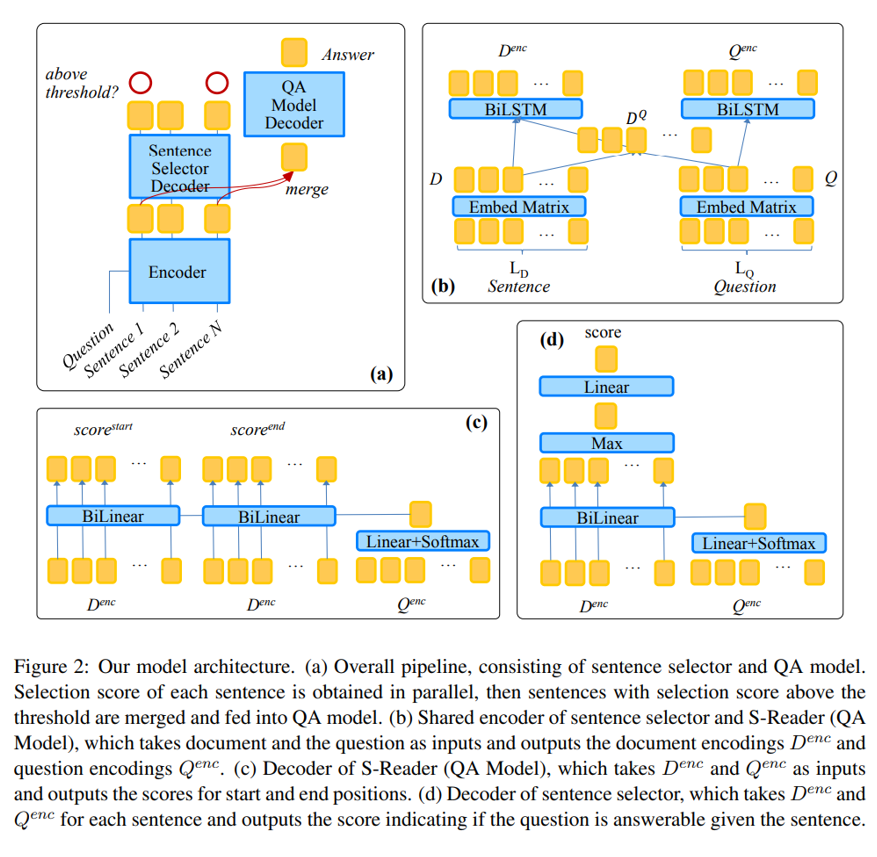

This is the start token classifier (where we get the starting position of our answer). The end token classifier also has a similar structure.
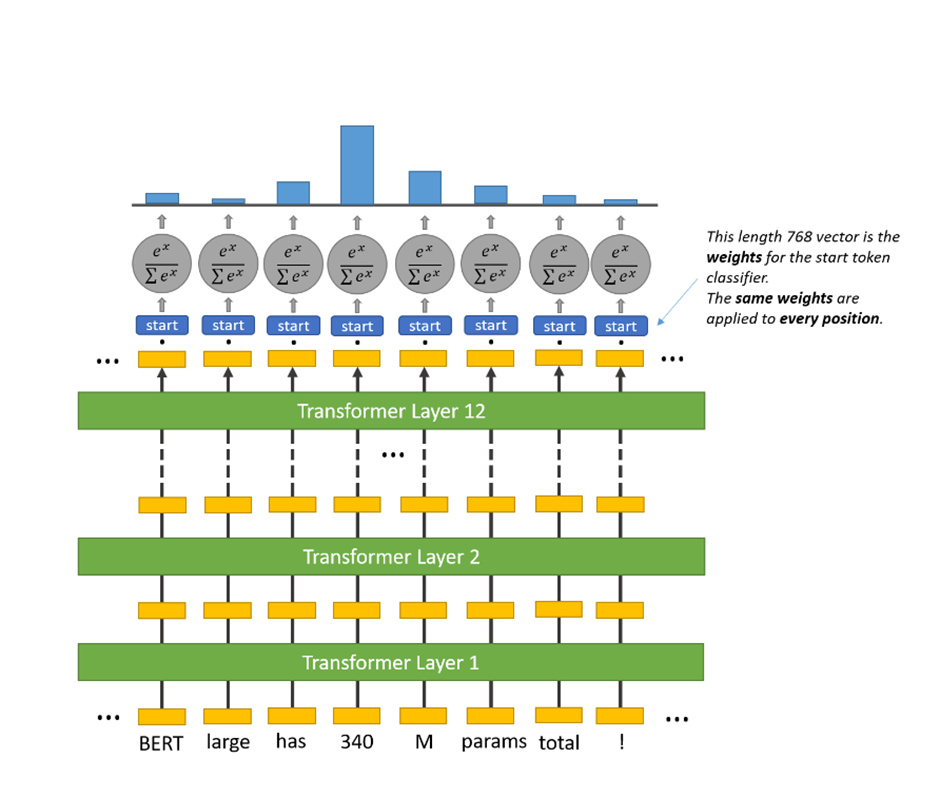

In [4]:
# Just an example:
tokenizer('hello i am in a building. i am not sure what i am doing over here.') # 16 characters, 18 tokens
# 101 means start of our context and 102 means end of context

{'input_ids': [101, 7592, 1045, 2572, 1999, 1037, 2311, 1012, 1045, 2572, 2025, 2469, 2054, 1045, 2572, 2725, 2058, 2182, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Each word has a specified number given by the token. Bert already has positional, so we can add segment embeddings into this.

1. Additionally, the combined length of our query and context tokens may exceed the maximum length of our input tokens. For this, we can set the truncate to be 'only-second' ( the second input is typically the context in the query context pair ). So the context is cut down.
2. We can extract the starting and ending indices of our answer by setting 'return_offset_mapping = True'
3. Let us make a function to apply 'truncate' and 'return_offset_mapping'; then we will proceed to apply this on our dataset by using the 'map' function.

##### Note: the offset map, as its name suggests, is the offset value comparing the position in the string vs the position in the tokens

### Function: 'preprocess_tokenize'

In [8]:
def preprocess_tokenize(example_data):
    question_list = [q.strip() for q in example_data['question']] 
    # this is basically a list of questions but stripped of unnecesaary whitespaces in the start and end of the question
    inputs = tokenizer(
        question_list,
        example_data['context'],
        max_length = 512,
        truncation = 'only_second',
        return_offsets_mapping = True,
        padding = 'max_length'
    )

    # extract the offset maps, answers
    offset_mapping = inputs.pop("offset_mapping")
    answers = example_data["answers"]
    starting_positions = []
    ending_positions = []
    
    ## every answer in the dataset is a dictionary having the text first and then the starting index of the answer. We need to iterate over every answer
    ## and manually access its start index and length of text for end index.
    for i, offset in enumerate(offset_mapping):

        # Step 1: Finding start and end of answer!
        answer = answers[i]
        start_id = answer['answer_start'][0] # because in the dictionary answer_start is a list with a single element. Same with text
        end_id = answer['answer_start'][0] + len(answer['text'][0])
        sequence_ids = inputs.sequence_ids(i)
        
        # Step 2: Finding start and end of context: sequence id is 0 for question, None for special tokens and 1 for start of context
        index = 0
        while sequence_ids[index] != 1: # covers case of sequence ID = 0 or None
            index += 1
        context_start = index
        while sequence_ids[index] == 1:
            index += 1
        context_end = index - 1 # when it becomes 1, we do not want to include that index

        # Step 3: If answer doesnt lie inside the context, set starting, ending positions to (0,0)
                # here we will use the offset indices to compare. offset taking in string indices and makes them token indices
        if offset[context_start][0] > end_id or offset[context_end][1] < start_id:
            starting_positions.append(0)
            ending_positions.append(0)

        else: # otherwise its the start and end token positions
              # we have the index set to context start.
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_id: # within range, and as soon as it reaches starting id, break the loop
                idx +=1
            starting_positions.append(idx -1)

            while idx >= context_start and offset[idx][1] >= end_id:
                idx -= 1
            ending_positions.append(idx + 1)        

    inputs['start_positions'] = starting_positions
    inputs['end_positions'] = ending_positions

    return inputs

#### Apply preprocessing function over the dataset

In [9]:
processed_squad = squad.map(preprocess_tokenize, batched=True)
# but we do not want the columns of id, context, title anymore! so we have to drop them
processed_squad['train'] = processed_squad['train'].remove_columns(['id', 'title', 'context', 'question', 'answers'])
processed_squad['test'] = processed_squad['test'].remove_columns(['id', 'title', 'context', 'question', 'answers'])
processed_squad

Map:   0%|          | 0/70079 [00:00<?, ? examples/s]

Map:   0%|          | 0/17520 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 70079
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 17520
    })
})

When making batches, we also need to augment data randomly... check this out later

In [10]:
model = AutoModelForQuestionAnswering.from_pretrained("distilbert/distilbert-base-uncased")

training_args = TrainingArguments(
    output_dir='Checkpoints_distil_bert_qa_model_fullData',          # output directory
    overwrite_output_dir=True,
    num_train_epochs=3,              
    per_device_train_batch_size=8,  
    per_device_eval_batch_size=8,   
    warmup_steps=20,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,              
)

trainer = Trainer(
    model = model,                
    args = training_args,                  # training arguments, defined above
    train_dataset = processed_squad['train'],         
    eval_dataset = processed_squad['test'],
    tokenizer = tokenizer
    # compute_metrics = compute_metrics
)

C:\Users\Siddh Singhal\AppData\Roaming\Python\Python311\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Siddh Singhal\AppData\Roaming\Python\Python311\site-packages\accelerate\accelerator.py:444: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConf

In [11]:
trainer.train()

Step,Training Loss
500,3.306200
1000,2.137100
1500,1.819100
2000,1.721500
2500,1.632100
3000,1.592500
3500,1.525100
4000,1.527100
4500,1.487200
5000,1.483800


Checkpoint destination directory Checkpoints_distil_bert_qa_model_fullData\checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory Checkpoints_distil_bert_qa_model_fullData\checkpoint-1000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


TrainOutput(global_step=26280, training_loss=1.0222715694247497, metrics={'train_runtime': 13409.5102, 'train_samples_per_second': 15.678, 'train_steps_per_second': 1.96, 'total_flos': 2.7468115791427584e+16, 'train_loss': 1.0222715694247497, 'epoch': 3.0})

#### Saving the model onto our system.

In [12]:
trainer.save_model("test-squad-trained-fullData")

In [27]:
question = "what is their behaviour?"
context = "The bulbul bird, a member of the Pycnonotidae family, is a charming and melodious songbird found across Asia, Africa, and the Middle East. These medium-sized birds, typically measuring between 15 to 20 centimeters in length, are renowned for their vibrant plumage, which can range from dull browns and olives to striking reds and yellows depending on the species. Bulbuls are highly adaptable, inhabiting a variety of environments from dense forests and scrublands to urban gardens and farmlands. One of the most distinguishing features of bulbuls is their vocal prowess; their calls are a delightful array of whistles, trills, and chatters that add a musical backdrop to their habitats. They are primarily frugivorous, feeding on a wide range of fruits and berries, though they also consume insects and small invertebrates, playing a crucial role in seed dispersal and pest control. Social and active, bulbuls are often seen in pairs or small groups, exhibiting a playful behavior that endears them to bird watchers and nature enthusiasts. During the breeding season, which varies by region but often aligns with the onset of warmer months, bulbuls construct neat, cup-shaped nests in trees or shrubs, where they lay two to three eggs. Their adaptability, combined with their pleasing appearance and melodious songs, makes bulbuls a beloved species across their range, contributing to the biodiversity and ecological balance of their habitats."

#### Using a pipeline to extract an answer from the context.

In [28]:
from transformers import pipeline
question_answerer = pipeline("question-answering", model="test-squad-trained-fullData")
question_answerer(question=question, context=context)

{'score': 0.2577953338623047,
 'start': 42,
 'end': 107,
 'answer': 'hot, dry climates. It is cultivated in subtropical regions around'}

Let us finally proceed to deploying our model!